<a href="https://colab.research.google.com/github/Shiva8164/Plagiarism_Checker_ai/blob/main/Plagiarism_checker2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = "/content/drive/MyDrive/train_snli.txt"
with open(file_path, "r") as file:
    content = file.read()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [ ]:
df = pd.read_csv(file_path, delimiter="\t", header=None, names=["Original_text", "Plagiarism_text", "Label"])

In [ ]:
df.isnull().sum()

,0
Original_text,0
Plagiarism_text,4
Label,0


In [ ]:
df.dropna(inplace=True)

In [ ]:
df['Label'].value_counts()

,count
Label,
0,183964
1,183405


<ipython-input-8-075323fd5ebf>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette=["#2E4053", "#A93226"])


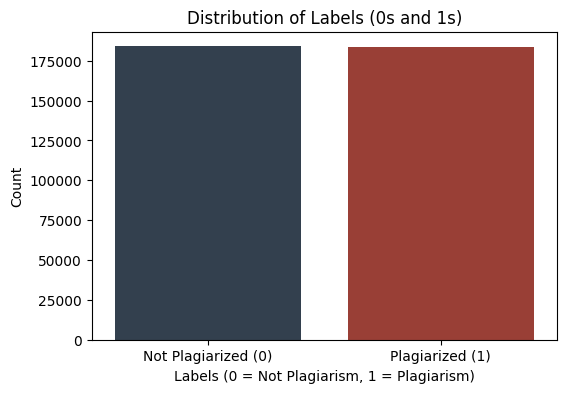

In [ ]:
label_counts = df["Label"].value_counts()

plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette=["#2E4053", "#A93226"])

plt.xlabel("Labels (0 = Not Plagiarism, 1 = Plagiarism)")
plt.ylabel("Count")
plt.title("Distribution of Labels (0s and 1s)")
plt.xticks([0, 1], labels=["Not Plagiarized (0)", "Plagiarized (1)"])
plt.show()

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
def cleaning_data(data):
  data = data.lower()
  data = re.sub(r'[^\w\s]', '', data)
  stopword = set(stopwords.words('english'))
  data = ' '.join([x for x in data.split() if x not in stopword])
  lemmatizer = WordNetLemmatizer()
  data = ' '.join([lemmatizer.lemmatize(x) for x in data.split()])
  return data

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
df["Original_text"] = df["Original_text"].apply(cleaning_data)
df["Plagiarism_text"] = df["Plagiarism_text"].apply(cleaning_data)

In [11]:
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
embedded_sentence1 = sbert_model.encode(df["Original_text"].tolist())
embedded_sentence2 = sbert_model.encode(df["Plagiarism_text"].tolist())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [12]:
X = np.abs(embedded_sentence1 - embedded_sentence2)

y = df["Label"].values

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
X = pca.fit_transform(X)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [15]:
LR = LogisticRegression()
LR_trained = LR.fit(X_train, y_train)
LR_pred = LR.predict(X_test)
LR_accuracy = accuracy_score(y_test, LR_pred)
print("Accuracy: ", LR_accuracy)
print(classification_report(y_test, LR_pred))

Accuracy:  0.7908239649399788
              precision    recall  f1-score   support

           0       0.79      0.78      0.79     36586
           1       0.79      0.80      0.79     36888

    accuracy                           0.79     73474
   macro avg       0.79      0.79      0.79     73474
weighted avg       0.79      0.79      0.79     73474



In [16]:
!pip install lightgbm

In [17]:
import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'verbose': -1
}

lgbm_model = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=100)

In [18]:
y_pred = lgbm_model.predict(X_test)
y_pred = np.round(y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8090

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.77      0.80     36586
           1       0.79      0.85      0.82     36888

    accuracy                           0.81     73474
   macro avg       0.81      0.81      0.81     73474
weighted avg       0.81      0.81      0.81     73474



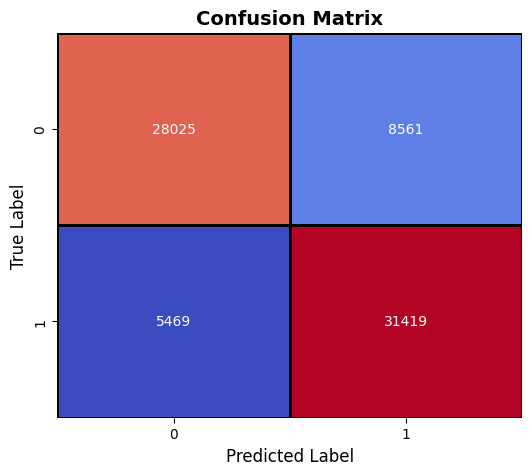

In [19]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", cbar=False, linewidths=2, linecolor='black')

plt.xlabel("Predicted Label", fontsize=12, color="black")
plt.ylabel("True Label", fontsize=12, color="black")
plt.title("Confusion Matrix", fontsize=14, fontweight="bold", color="black")

plt.show()

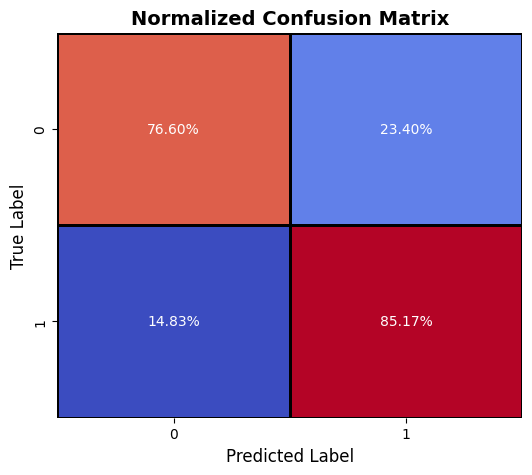

In [20]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6,5))
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap="coolwarm", cbar=False, linewidths=2, linecolor='black')

plt.xlabel("Predicted Label", fontsize=12, color="black")
plt.ylabel("True Label", fontsize=12, color="black")
plt.title("Normalized Confusion Matrix", fontsize=14, fontweight="bold", color="black")

plt.show()

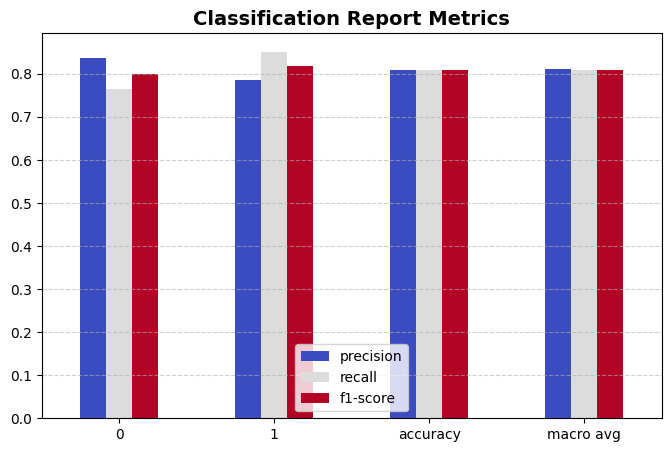

In [21]:
import pandas as pd

from sklearn.metrics import classification_report
report_dict = classification_report(y_test, y_pred, output_dict=True)

df_report = pd.DataFrame(report_dict).transpose()

df_report.drop(columns=['support'], inplace=True)

df_report[:-1].plot(kind="bar", colormap="coolwarm", figsize=(8,5))
plt.title("Classification Report Metrics", fontsize=14, fontweight="bold")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


In [27]:
import joblib

model_save_path = "/content/drive/MyDrive/lightgbm_plagiarism_model.pkl"

joblib.dump(lgbm_model, model_save_path)

print(f"Model saved at: {model_save_path}")

Model saved at: /content/drive/MyDrive/lightgbm_plagiarism_model.pkl


In [28]:
logreg_path = "/content/drive/MyDrive/logistic_regression_model.pkl"


In [29]:
joblib.dump(LR_trained, model_save_path)

print(f"Model saved at: {model_save_path}")

Model saved at: /content/drive/MyDrive/lightgbm_plagiarism_model.pkl


In [31]:
pca_save_path = "/content/drive/MyDrive/pca_model.pkl"
joblib.dump(pca, pca_save_path)

print(f"PCA model saved at: {pca_save_path}")

PCA model saved at: /content/drive/MyDrive/pca_model.pkl
